# Project 4: Data Wrangling

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Gather</a></li>
<li><a href="#asses">Assess</a></li>
<li><a href="#clean">Clean</a></li>
<li><a href="#save">Save</a></li>
<li><a href="#visualize">Visualize</a></li>
</ul>

<a id='intro'></a>
## Introduction

In the project, data wrangling is performed on WeRateDogs dataset, which is the tweet archive of the Twitter user @dog_rates. Data wrangling consists of three steps - gathering, assessing and cleaning. Data is gathered from three different sources, which include files on local device and Udacity's server, as well as Udacity's server. Subsequently, data is assessed with visual and programmatic assessments to look for data quality and tidiness issues. Finally, the data is cleaned based on the issues found in assessment.

<a id='gather'></a>
## Gather

Data is gathered from the following three sources:
<ul>
<li>CSV file on local device</li>
<li>TSV file on Udacity's server</li>
<li>Twitter's database</li>
</ul>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import json
import re

> Source 1: CSV file on local device

In [2]:
# Load CSV file and print out the first five rows
tweets = pd.read_csv('twitter-archive-enhanced.csv')
tweets.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


> Source 2: TSV file on Udacity's server

In [3]:
# Define URL for TSV file on Udacity's server
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

# Download TSV file from Udacity's server
response = requests.get(url)

with open(url.split('/')[-1], mode='wb') as file:
    file.write(response.content)

In [4]:
# Load TSV file and print out the first five rows
images_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
images_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


> Source 3: Twitter's database

In [5]:
# Set Consumer API keys, Access Token and Access Token Secret
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# Create wrapper for the API provided by Twitter
api = tweepy.API(auth)

In [6]:
# Define list for ids of existing and deleted tweets
existing_ids = []
deleted_ids = []

with open('tweet_json.txt', 'w') as file:
    for i, tweet_id in enumerate(tweets.tweet_id):
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')       
            # Write JSON object to file                       
            file.write(json.dumps(tweet._json))
            file.write('\n')
        
            existing_ids.append(tweet_id)
                               
        except Exception as e:
            deleted_ids.append(tweet_id)
        
        print("{} - {}/{}".format(tweet_id, i+1, len(tweets.tweet_id)))

In [7]:
# List of dictionaries to build and convert to a DataFrame later
df_list = []

with open('tweet_json.txt', 'r', encoding='utf-8') as file:
    for line in file:
        json_data = json.loads(line)
        tweet_id = json_data['id']
        favorite_count = json_data['favorite_count']
        retweet_count = json_data['retweet_count']
        
        # Append to list of dictionaries
        df_list.append({'tweet_id': tweet_id,
                        'favorite_count': favorite_count,
                        'retweet_count': retweet_count})
        
# Create DataFrame from list of dictionaries
tweets_additional_info = pd.DataFrame(df_list, columns = ['tweet_id', 'favorite_count', 'retweet_count'])
    
# Print out the first five rows
tweets_additional_info.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,35715,7548
1,892177421306343426,30871,5594
2,891815181378084864,23212,3704
3,891689557279858688,39008,7730
4,891327558926688256,37262,8332


<a id='assess'></a>
## Assess

Data is assessed with visual and programmatic assessment to look for data quality and tidiness issues

#### Visual Assessment

In [8]:
tweets

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [9]:
images_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [10]:
tweets_additional_info

,tweet_id,favorite_count,retweet_count
0,892420643555336193,35715,7548
1,892177421306343426,30871,5594
2,891815181378084864,23212,3704
3,891689557279858688,39008,7730
4,891327558926688256,37262,8332
5,891087950875897856,18786,2794
6,890971913173991426,10913,1814
7,890729181411237888,60190,16894
8,890609185150312448,25840,3848
9,890240255349198849,29501,6569


#### Programmatic Assessment

In [11]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
tweets.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [13]:
images_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
images_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [15]:
tweets_additional_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 3 columns):
tweet_id          864 non-null int64
favorite_count    864 non-null int64
retweet_count     864 non-null int64
dtypes: int64(3)
memory usage: 20.3 KB


In [16]:
tweets_additional_info.describe()

,tweet_id,favorite_count,retweet_count
count,8.640000e+02,864.000000,864.000000
mean,8.209909e+17,13803.471065,4697.010417
std,3.645843e+16,14454.990883,5273.699132
min,7.529173e+17,0.000000,1.000000
25%,7.906696e+17,5301.750000,1958.500000
50%,8.190109e+17,10504.000000,3213.000000
75%,8.491231e+17,19381.250000,5479.250000
max,8.924206e+17,131340.000000,55612.000000


In [17]:
# Look for rows that correspond to retweets
tweets.loc[tweets['retweeted_status_id'].isin(tweets['tweet_id'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None
109,871166179821445120,NaN,NaN,2017-06-04 00:46:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Dawn. She's just checki...,8.410770e+17,4.196984e+09,2017-03-13 00:02:39 +0000,https://twitter.com/dog_rates/status/841077006...,12,10,Dawn,None,None,None,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None


In [18]:
# Determine unique values for rating_numerator
tweets.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [19]:
# Determine unique values for rating_denominator
tweets.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [20]:
# Determine invalid dog names - Part 1
tweets[~tweets.name.str[0].str.isupper()].name.value_counts()

a               55
the              8
an               7
very             5
one              4
just             4
quite            4
getting          2
actually         2
mad              2
not              2
old              1
life             1
space            1
by               1
unacceptable     1
infuriating      1
all              1
light            1
officially       1
this             1
my               1
such             1
incredibly       1
his              1
Name: name, dtype: int64

In [21]:
# Determine invalid dog names - Part 2
tweets[tweets.name.str.contains('^.$')].name.value_counts()

a    55
O     1
Name: name, dtype: int64

#### Quality
##### `tweets` table
- Some of the tweets are retweets
- Erroneous datatypes (tweet_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id & retweeted_status_user_id columns) - should be string
- Erroneous datatypes (timestamp & retweeted_status_timestamp columns) - should be datetime
- None instead of NaN in doggo, floofer, pupper and puppo columns
- Invalid numerator values such as 960, 75, 27, 50, 26
- Numerator rating should be float64 as some ratings have decimal values
- Invalid denominator values such as 0, 11, 20, 50, 2
- Tweets with tweet_id of 832088576586297345, 682808988178739200 & 810984652412424192 do not have dog rating
- Invalid dog names such as a, the, infuriating, officially, unacceptable and O
- None instead of NaN in name column

##### `images_predictions` table
- Inconsistent naming convention for values in p1, p2 and p3 columns (for e.g. Maltese_dog, golden_retriever, soft-coated_wheaten_terrier & Chihuahua
- Erroneous datatypes (tweet_id & img_num columns) - should be string

##### `tweets_additional_info` table
- Erroneous datatypes (tweet_id column) - should be string


#### Tidiness
- 'doggo', 'floofer', 'pupper', 'puppo' should be combined into one column and None instead of NaN in these columns
- All three data frames should be combined into one data frame

<a id='clean'></a>
## Clean

Data is clean based on data quality and tidiness issues found in the assessment stage.

In [22]:
# Create copies of the three dataframes
tweets_clean = tweets.copy()
images_predictions_clean = images_predictions.copy()
tweets_additional_info_clean = tweets_additional_info.copy()

### Tidiness

#### `doggo`, `floofer`, `pupper`, `puppo` should be combined into one column and None instead of NaN in these columns

##### Define
*Create `dog_stage` from `doggo`, `floofer`, `pupper` and `puppo`. Replace None or empty cell in `dog_stage` with NaN.*

##### Code

In [23]:
tweets_clean = tweets.copy()

# Replace None with empty string
tweets_clean.doggo.replace('None', '', inplace=True)
tweets_clean.floofer.replace('None', '', inplace=True)
tweets_clean.pupper.replace('None', '', inplace=True)
tweets_clean.puppo.replace('None', '', inplace=True)

# Combine 'doggo', 'floofer', 'pupper', 'puppo' into one column with the name of 'dog_stages'
tweets_clean['dog_stages'] = tweets_clean.doggo + tweets_clean.floofer + tweets_clean.pupper + tweets_clean.puppo

# Separate two dog stages with a comma
tweets_clean.loc[tweets_clean.dog_stages == 'doggopupper', 'dog_stages'] = 'doggo, pupper'
tweets_clean.loc[tweets_clean.dog_stages == 'doggopuppo', 'dog_stages'] = 'doggo, puppo'
tweets_clean.loc[tweets_clean.dog_stages == 'doggofloofer', 'dog_stages'] = 'doggo, floofer'

# Delete  'doggo', 'floofer', 'pupper', 'puppo' columns
tweets_clean.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace = True)

# Replace empty cell with NaN
tweets_clean.dog_stages.replace('', np.nan, inplace=True)

##### Test

In [24]:
tweets_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN


In [25]:
tweets_clean.dog_stages.value_counts()

pupper            245
doggo              83
puppo              29
doggo, pupper      12
floofer             9
doggo, floofer      1
doggo, puppo        1
Name: dog_stages, dtype: int64

#### All three data frames should be combined into one data frame

##### Define
Merge `tweets_clean`, `images_predictions_clean`, `tweets_additional_info` tables, joining on `tweet_id`.

##### Code

In [26]:
# Merge tweets_clean, images_predictions_clean, tweets_additional_info tables, joining on tweet_id

tweets_master_clean = pd.merge(tweets_clean, images_predictions_clean, on='tweet_id', how='left')
tweets_master_clean = pd.merge(tweets_master_clean, tweets_additional_info_clean, on='tweet_id', how='left')

##### Test

In [27]:
tweets_master_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,35715.0,7548.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,30871.0,5594.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,23212.0,3704.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,39008.0,7730.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,37262.0,8332.0


In [28]:
tweets_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_stages                    380 non-null object
jpg_url                       2075 non-null object
img_num                       2075 non-null float64
p1                            2075 non-null object
p1_conf                       20

### Quality

#### Some of the tweets are retweets

##### Define
*Drop rows that correspond to retweets.*

##### Code

In [29]:
# Drop rows that correspond to retweets
bool_index_retweets = tweets_master_clean['retweeted_status_id'].isin(tweets_master_clean['tweet_id'])
tweets_master_clean.drop(tweets_master_clean[bool_index_retweets].index, inplace=True)

# Reset indices after dropping retweets
tweets_master_clean.reset_index(drop=True, inplace=True)

##### Test

In [30]:
tweets_master_clean[tweets_master_clean['retweeted_status_id'].isin(tweets_master_clean['tweet_id'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count


In [31]:
tweets_master_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,35715.0,7548.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,30871.0,5594.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,23212.0,3704.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,39008.0,7730.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,37262.0,8332.0
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,...,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,18786.0,2794.0
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,10913.0,1814.0
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,...,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,60190.0,16894.0
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,...,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True,25840.0,3848.0
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,...,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,29501.0,6569.0


#### Erroneous datatypes (tweet_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id & retweeted_status_user_id columns) - should be string

##### Define
*Convert the data types of tweet_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id & retweeted_status_user_id columns from float or int to string using `astype`.*

##### Code

In [32]:
# Convert the data types of tweet_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id & 
# retweeted_status_user_id columns from float or int to string
tweets_master_clean.tweet_id = tweets_master_clean.tweet_id.astype(str)
tweets_master_clean.in_reply_to_status_id = tweets_master_clean.in_reply_to_status_id.astype(str)
tweets_master_clean.in_reply_to_user_id = tweets_master_clean.in_reply_to_user_id.astype(str)
tweets_master_clean.retweeted_status_id = tweets_master_clean.retweeted_status_id.astype(str)
tweets_master_clean.retweeted_status_user_id = tweets_master_clean.retweeted_status_user_id.astype(str)

##### Test

In [33]:
tweets_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 27 columns):
tweet_id                      2200 non-null object
in_reply_to_status_id         2200 non-null object
in_reply_to_user_id           2200 non-null object
timestamp                     2200 non-null object
source                        2200 non-null object
text                          2200 non-null object
retweeted_status_id           2200 non-null object
retweeted_status_user_id      2200 non-null object
retweeted_status_timestamp    25 non-null object
expanded_urls                 2141 non-null object
rating_numerator              2200 non-null int64
rating_denominator            2200 non-null int64
name                          2200 non-null object
dog_stages                    348 non-null object
jpg_url                       2009 non-null object
img_num                       2009 non-null float64
p1                            2009 non-null object
p1_conf                       

#### Erroneous datatypes (timestamp & retweeted_status_timestamp columns) - should be datetime

##### Define
*Convert the data types of timestamp & retweeted_status_timestamp columns from string to datetime.*

##### Code

In [34]:
# Convert the data types of timestamp & retweeted_status_timestamp columns from string to datetime
tweets_master_clean.timestamp = pd.to_datetime(tweets_master_clean.timestamp)
tweets_master_clean.retweeted_status_timestamp = pd.to_datetime(tweets_master_clean.retweeted_status_timestamp)

##### Test

In [35]:
tweets_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 27 columns):
tweet_id                      2200 non-null object
in_reply_to_status_id         2200 non-null object
in_reply_to_user_id           2200 non-null object
timestamp                     2200 non-null datetime64[ns]
source                        2200 non-null object
text                          2200 non-null object
retweeted_status_id           2200 non-null object
retweeted_status_user_id      2200 non-null object
retweeted_status_timestamp    25 non-null datetime64[ns]
expanded_urls                 2141 non-null object
rating_numerator              2200 non-null int64
rating_denominator            2200 non-null int64
name                          2200 non-null object
dog_stages                    348 non-null object
jpg_url                       2009 non-null object
img_num                       2009 non-null float64
p1                            2009 non-null object
p1_conf       

#### Invalid numerator values (such as 960, 75, 27, 50 & 26) and invalid denominator values (such as 0, 11, 20, 50 & 2). Data type of numerator rating should be float64 as some numerator ratings have decimal values.

##### Define
*Extract numerator and denominator values from text, and convert data type of `rating numerator` from int to float.*

##### Code

In [36]:
# Define functions to extract rating from text
def extract_rating(text):
    list_of_words = text.split(" ")
    
    # Extract words in the form of rating from the list
    regex = re.compile(r'(?:\d+\.)?\d+\/(?:\d+\.)?\d+')
    rating = list(filter(regex.search, list_of_words))
    
    # Use the last element in list as rating because sometimes there are mulitple words in the form of rating
    # and the last word is often the actual rating
    rating = rating[-1]
    return rating
    
# Extract ratings from text 
ratings = tweets_master_clean.text.apply(lambda x: extract_rating(x))

# Split rating into numerator and denominator values
tweets_master_clean['rating_numerator'], tweets_master_clean['rating_denominator'] = ratings.str.split('/', 1).str

# Remove non-numeric letter from rating_numerator and rating_denominator
regex_rating = '((?:\d+\.)?\d+)'
tweets_master_clean['rating_numerator'] = tweets_master_clean['rating_numerator'].str.extract(regex_rating, expand=False)
tweets_master_clean['rating_denominator'] = tweets_master_clean['rating_denominator'].str.extract(regex_rating, expand=False)

# Convert data type of rating_numerator from string to float
tweets_master_clean['rating_numerator'] = pd.to_numeric(tweets_master_clean['rating_numerator'], errors='ignore')

# Convert data type of rating_denominator from string to int
tweets_master_clean['rating_denominator'] = pd.to_numeric(tweets_master_clean['rating_denominator'], errors='ignore', downcast='integer')


##### Test

In [37]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
tweets_master_clean['rating_numerator'].unique()

array([13.000, 12.000, 14.000, 13.500, 11.000, 10.000, 420.000, 666.000,
       6.000, 15.000, 182.000, 0.000, 7.000, 84.000, 24.000, 9.750, 5.000,
       11.270, 3.000, 8.000, 9.000, 4.000, 165.000, 1776.000, 2.000,
       204.000, 99.000, 80.000, 45.000, 60.000, 44.000, 1.000, 143.000,
       121.000, 20.000, 9.500, 11.260, 144.000, 88.000])

In [38]:
tweets_master_clean['rating_denominator'].unique()

array([ 10,  15,  70,   7, 150, 170,  90,  80,  50,  40,  20, 130, 110,
        16, 120])

In [39]:
tweets_master_clean.describe()

,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf,favorite_count,retweet_count
count,2200.000000,2200.000000,2009.000000,2009.000000,2.009000e+03,2.009000e+03,732.000000,732.000000
mean,12.714673,10.471818,1.202588,0.594467,1.340727e-01,6.017061e-02,16292.621585,4281.077869
std,42.912275,6.919279,0.559483,0.272236,1.006394e-01,5.085369e-02,14355.032705,5077.291069
min,0.000000,7.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,0.000000,1.000000
25%,10.000000,10.000000,1.000000,0.362925,5.353130e-02,1.610520e-02,7859.500000,1847.500000
50%,11.000000,10.000000,1.000000,0.588230,1.170030e-01,4.947150e-02,12274.500000,2955.500000
75%,12.000000,10.000000,1.000000,0.847292,1.948970e-01,9.157150e-02,20929.750000,4770.500000
max,1776.000000,170.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,131340.000000,55612.000000


In [40]:
tweets_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 27 columns):
tweet_id                      2200 non-null object
in_reply_to_status_id         2200 non-null object
in_reply_to_user_id           2200 non-null object
timestamp                     2200 non-null datetime64[ns]
source                        2200 non-null object
text                          2200 non-null object
retweeted_status_id           2200 non-null object
retweeted_status_user_id      2200 non-null object
retweeted_status_timestamp    25 non-null datetime64[ns]
expanded_urls                 2141 non-null object
rating_numerator              2200 non-null float64
rating_denominator            2200 non-null int16
name                          2200 non-null object
dog_stages                    348 non-null object
jpg_url                       2009 non-null object
img_num                       2009 non-null float64
p1                            2009 non-null object
p1_conf     

#### Tweets with tweet_id of 832088576586297345, 682808988178739200 & 810984652412424192 do not have dog rating

##### Define
*Remove tweets with tweet_id of 832088576586297345, 682808988178739200 & 810984652412424192 from the data frame.*

##### Code

In [41]:
# Define the list ofinvalid tweet ids
invalid_tweet_id = [832088576586297345, 682808988178739200, 810984652412424192]

# Remove invalid tweets from the data frame
tweets_master_clean = tweets_master_clean.loc[~tweets_master_clean.tweet_id.isin(invalid_tweet_id)]

##### Test

In [42]:
tweets_master_clean.loc[tweets_master_clean.tweet_id.isin(invalid_tweet_id)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count


#### Invalid dog names such as a, the, infuriating, officially, unacceptable and O, and None instead of NaN in name column.

##### Define
*Replace invalid dog names and None with NaN.*

##### Code

In [43]:
# Replace invalid dog names and None with NaN
invalid_names = ["a", "the", "an", "very", "quite", "just", "one", "mad", "not", "getting",
                 "actually", "space", "such", "his", "infuriating", "life", "old", "light",
                 "my", "all", "unacceptable", "by", "officially", "this", "incredibly", "O", "None"]

for name in invalid_names:
    tweets_master_clean.name.replace(name, np.nan, inplace=True)

##### Test

In [44]:
tweets_master_clean.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', nan, 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'Canela', 'Maya', 'Mingus',
       'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Earl', 'Lola',
       'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald', 'Rusty', 'Gus',
       'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'Elliot', 'Louis',
       'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Steven', 'Beau',
       'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny', 'Dante', 'Nelly',
       'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget', 'Cash', 'Jed',
       'Sebastian', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Boomer', 'Cody', 'Rumble', 'Clifford', 'Dewey',
       'Scout', 'Gizmo', 'Walter', 'Cooper', 'Harold', 'Shikha', 'Lili',
       'Jamesy', 'Coco', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave', 'Jersey', 'Hobbes',


In [45]:
tweets_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2200 entries, 0 to 2199
Data columns (total 27 columns):
tweet_id                      2200 non-null object
in_reply_to_status_id         2200 non-null object
in_reply_to_user_id           2200 non-null object
timestamp                     2200 non-null datetime64[ns]
source                        2200 non-null object
text                          2200 non-null object
retweeted_status_id           2200 non-null object
retweeted_status_user_id      2200 non-null object
retweeted_status_timestamp    25 non-null datetime64[ns]
expanded_urls                 2141 non-null object
rating_numerator              2200 non-null float64
rating_denominator            2200 non-null int16
name                          1391 non-null object
dog_stages                    348 non-null object
jpg_url                       2009 non-null object
img_num                       2009 non-null float64
p1                            2009 non-null object
p1_conf     

#### Inconsistent naming convention for values in p1, p2 and p3 columns (for e.g. Maltese_dog, golden_retriever, soft-coated_wheaten_terrier & Chihuahua)

##### Define
*Replace "_" with space and make the first letter of every word uppercase*

##### Code

In [46]:
cols_list = ['p1', 'p2', 'p3']

for col in cols_list:
    tweets_master_clean[col] = tweets_master_clean[col].str.replace('_', ' ').str.title()  

##### Test

In [47]:
tweets_master_clean[['p1','p2','p3']]

,p1,p2,p3
0,Orange,Bagel,Banana
1,Chihuahua,Pekinese,Papillon
2,Chihuahua,Malamute,Kelpie
3,Paper Towel,Labrador Retriever,Spatula
4,Basset,English Springer,German Short-Haired Pointer
5,Chesapeake Bay Retriever,Irish Terrier,Indian Elephant
6,Appenzeller,Border Collie,Ice Lolly
7,Pomeranian,Eskimo Dog,Pembroke
8,Irish Terrier,Irish Setter,Chesapeake Bay Retriever
9,Pembroke,Cardigan,Chihuahua


#### Erroneous datatypes (img_num columns) - should be string

##### Define
*Convert the data type of img_num column from float to string.*

##### Code

In [48]:
# Convert the data type of img_num column from float to string
tweets_master_clean.img_num = tweets_master_clean.img_num.astype(str)

##### Test

In [49]:
tweets_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2200 entries, 0 to 2199
Data columns (total 27 columns):
tweet_id                      2200 non-null object
in_reply_to_status_id         2200 non-null object
in_reply_to_user_id           2200 non-null object
timestamp                     2200 non-null datetime64[ns]
source                        2200 non-null object
text                          2200 non-null object
retweeted_status_id           2200 non-null object
retweeted_status_user_id      2200 non-null object
retweeted_status_timestamp    25 non-null datetime64[ns]
expanded_urls                 2141 non-null object
rating_numerator              2200 non-null float64
rating_denominator            2200 non-null int16
name                          1391 non-null object
dog_stages                    348 non-null object
jpg_url                       2009 non-null object
img_num                       2200 non-null object
p1                            2009 non-null object
p1_conf      

<a id='save'></a>
## Save

After data wrangling is completed, the cleaned dataframe is saved to a CSV file

In [50]:
# Save cleaned dataframe to a CSV file on local device
tweets_master_clean.to_csv('twitter_archive_master.csv', index=False)

<a id='visualize'></a>
## Visualize

Wrangled data is analysed and visualized to create three insights and one visualization.

In [51]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

In [52]:
# Load CSV file and print out the first five rows
df_clean = pd.read_csv('twitter_archive_master.csv')
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False,35715.0,7548.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,30871.0,5594.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,23212.0,3704.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,0.170278,False,Labrador Retriever,0.168086,True,Spatula,0.040836,False,39008.0,7730.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.555712,True,English Springer,0.225770,True,German Short-Haired Pointer,0.175219,True,37262.0,8332.0


In [53]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 27 columns):
tweet_id                      2200 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2200 non-null object
source                        2200 non-null object
text                          2200 non-null object
retweeted_status_id           25 non-null float64
retweeted_status_user_id      25 non-null float64
retweeted_status_timestamp    25 non-null object
expanded_urls                 2141 non-null object
rating_numerator              2200 non-null float64
rating_denominator            2200 non-null int64
name                          1391 non-null object
dog_stages                    348 non-null object
jpg_url                       2009 non-null object
img_num                       2009 non-null float64
p1                            2009 non-null object
p1_conf                       200

### Insight 1: What are the most common breeds found by the neural network?

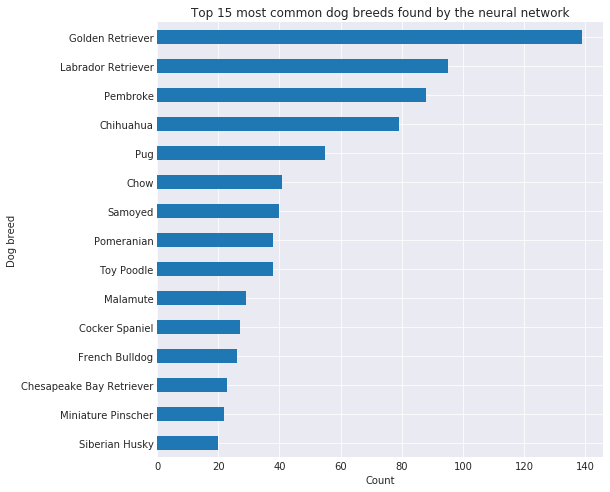

In [54]:
plt.figure(figsize=(8, 8)) # Set figure size
base_color = sns.color_palette()[0] # Set base color

# Extract rows with images and predictions of dog
df_clean_with_images = df_clean[df_clean.jpg_url.notna() & df_clean.p1_dog]

# Plot bar chart of the top 15 most common dog breeds found by the neural network
df_clean_with_images.p1.value_counts()[:15].sort_values().plot(kind = 'barh', color=base_color);
plt.title('Top 15 most common dog breeds found by the neural network')
plt.xlabel('Count');
plt.ylabel('Dog breed');

>The horizontal bar chart above shows the 15 most common dog breeds predicted by the neural network. As shown in the bar chart, the most common dogs breeds found by the neural network is golden retriever, followed by labrador retriever and pembroke.

### Insight 2: What are the most common dog names?

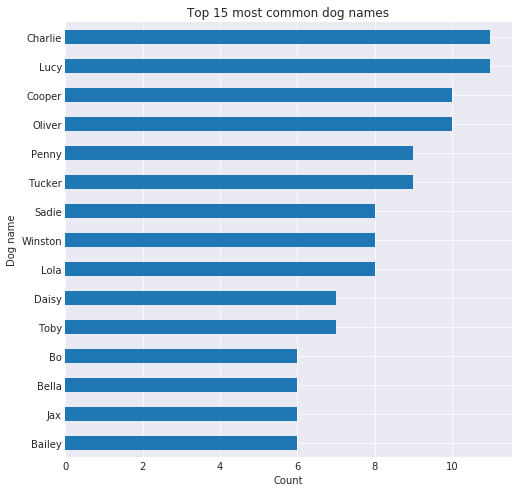

In [55]:
plt.figure(figsize=(8, 8)) # Set figure size
base_color = sns.color_palette()[0] # Set base color

# Plot bar chart of the top 15 most common dog names
df_clean.name.value_counts()[:15].sort_values().plot(kind = 'barh', color=base_color);
plt.title('Top 15 most common dog names')
plt.xlabel('Count');
plt.ylabel('Dog name');

>The horizontal bar chart above shows the 15 most common dog names in the dataset. As shown in the bar chart, Charlie and Lucy are the most common dog names, followed by Copper and Oliver (both are second most common dog names). Penny and Tucker are the third most common dog names.

### Insight 3: What is the most common dog stage?

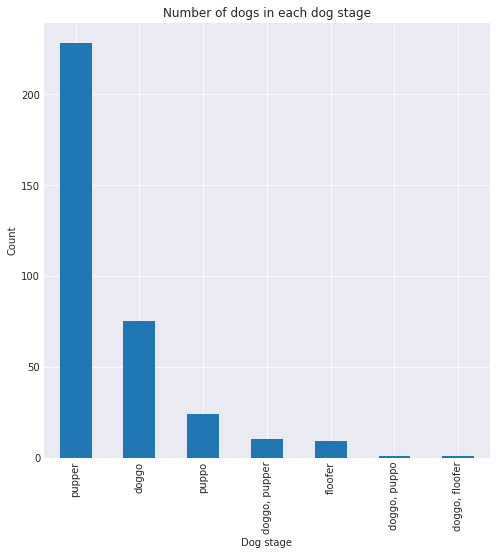

In [56]:
plt.figure(figsize=(8, 8)) # Set figure size
base_color = sns.color_palette()[0] # Set base color

# Plot bar chart of the number of dogs in each dog stage
df_clean.dog_stages.value_counts().sort_values(ascending=False).plot(kind = 'bar', color=base_color);
plt.title('Number of dogs in each dog stage')
plt.xlabel('Dog stage');
plt.ylabel('Count');

>From the bar chart, pupper is the most common dog stage, followed by doggo.

### Visualization: What is the relationship between favourite counts and retweet counts?

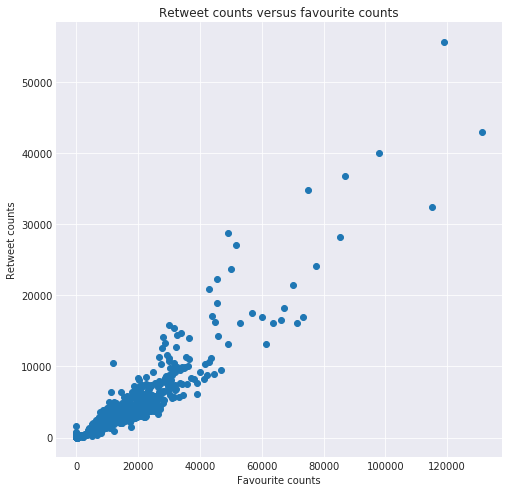

In [57]:
plt.figure(figsize=(8, 8)) # Set figure size

# Plot scatter plot between favourite counts and retweet counts
plt.scatter(data=df_clean, x='favorite_count', y='retweet_count')
plt.title('Retweet counts versus favourite counts')
plt.xlabel('Favourite counts')
plt.ylabel('Retweet counts');

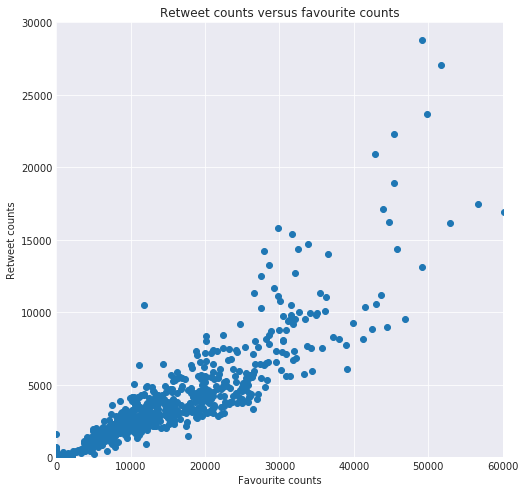

In [58]:
# Have a zoom-in view of the scatter plot
plt.figure(figsize=(8, 8)) # Set figure size
plt.scatter(data=df_clean, x='favorite_count', y='retweet_count')
plt.title('Retweet counts versus favourite counts')
plt.xlabel('Favourite counts')
plt.ylabel('Retweet counts')
plt.xlim(0, 60000)
plt.ylim(0, 30000);

>From the scatter plot, it can be seen that there is a positive correlation between favorite counts and retweet counts

### Summary

<ul>
<li>The most common dogs breed found by the neural network is golden retriever.</li>
<li>The most common dog names are Charlie and Lucy.</li>
<li>The most common dog stage is pupper.</li>
<li>There is a positive correlation between favorite counts and retweet counts.</li>
</ul>